In [2]:

# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.16.1
GPU Available: []


In [3]:
print("Loading data...")
train_data = pd.read_csv('data_minihackathon_train.csv')
test_data = pd.read_csv('data_minihackathon_test.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"\nTraining data info:")
print(train_data.info())
print(f"\nMissing values in training data:")
print(train_data.isnull().sum())

Loading data...
Training data shape: (1500, 14)
Test data shape: (377, 13)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             1500 non-null   int64  
 1   Age            1498 non-null   float64
 2   Gender         1499 non-null   float64
 3   Education      1480 non-null   float64
 4   Country        1498 non-null   float64
 5   Ethnicity      1500 non-null   float64
 6   Nscore         1499 non-null   float64
 7   Escore         1499 non-null   float64
 8   Oscore         1499 non-null   float64
 9   Ascore         1499 non-null   float64
 10  Cscore         1499 non-null   float64
 11  Impulsive      1499 non-null   float64
 12  SS             1500 non-null   float64
 13  drug_category  1500 non-null   object 
dtypes: float64(12), int64(1), object(1)
memory usage: 164.2+ KB
None

Missing values in trai

In [4]:
# Cell 3: Exploratory Data Analysis
print("\nTarget distribution:")
print(train_data['drug_category'].value_counts())


Target distribution:
drug_category
Hallucinogens    691
Stimulants       567
Depressants      242
Name: count, dtype: int64


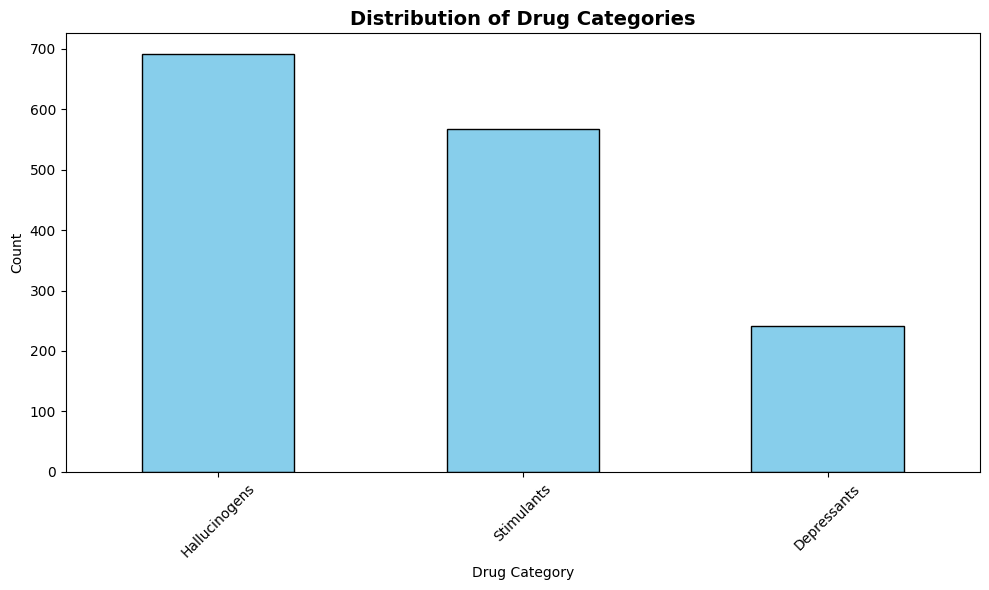

In [5]:
# Plot target distribution
plt.figure(figsize=(10, 6))
train_data['drug_category'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Drug Categories', fontsize=14, fontweight='bold')
plt.xlabel('Drug Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Cell 4: Data Preprocessing
# Separate features and target
X = train_data.drop(['ID', 'drug_category'], axis=1)
y = train_data['drug_category']
X_test = test_data.drop(['ID'], axis=1)
test_ids = test_data['ID']

In [7]:
print(f"Features shape: {X.shape}")
print(f"Features: {list(X.columns)}")

Features shape: (1500, 12)
Features: ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']


In [8]:
print("\nHandling missing values...")
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

print(f"Missing values after imputation: {X_imputed.isnull().sum().sum()}")


Handling missing values...
Missing values after imputation: 0


In [9]:
# Cell 5: Encode Target Variable
# Encode target labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")
print(f"Encoding mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name} -> {i}")

Number of classes: 3
Classes: ['Depressants' 'Hallucinogens' 'Stimulants']
Encoding mapping:
  Depressants -> 0
  Hallucinogens -> 1
  Stimulants -> 2


In [10]:
# Cell 6: Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_imputed, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())

Training set size: 1350
Validation set size: 150

Training set class distribution:
0    218
1    622
2    510
Name: count, dtype: int64


In [12]:
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_imputed)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [14]:
def create_improved_model(input_dim, num_classes, learning_rate=0.001):
    model = models.Sequential([
        # Deeper network with residual connections concept
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(256, activation='relu'),  # Wider
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Try different optimizer
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=1e-5  # L2 regularization
    )
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model
input_dim = X_train_scaled.shape[1]
model = create_improved_model(input_dim, num_classes)

# Display model architecture
print("Model Architecture:")
model.summary()

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,339 (306.01 KB)

 Trainable params: 77,187 (301.51 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [15]:
# Cell 10: Train Model
print("Training Neural Network...")
print("="*10)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    #callbacks=callback_list,
    verbose=1
)

print("\n✓ Training completed!")

Training Neural Network...
Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4592 - loss: 1.3596 - val_accuracy: 0.6533 - val_loss: 0.9211
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6492 - loss: 0.9388 - val_accuracy: 0.7067 - val_loss: 0.8688
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6517 - loss: 0.8922 - val_accuracy: 0.7200 - val_loss: 0.8331
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6509 - loss: 0.8538 - val_accuracy: 0.7000 - val_loss: 0.8373
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6997 - loss: 0.7957 - val_accuracy: 0.6933 - val_loss: 0.8627
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6821 - loss: 0.7671 - val_accuracy: 0.7000 - val_loss: 0.9022
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6699 - loss: 0.8274 - val_accuracy: 0.6800 - val_loss: 0.9287
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6878 - loss: 0.8113

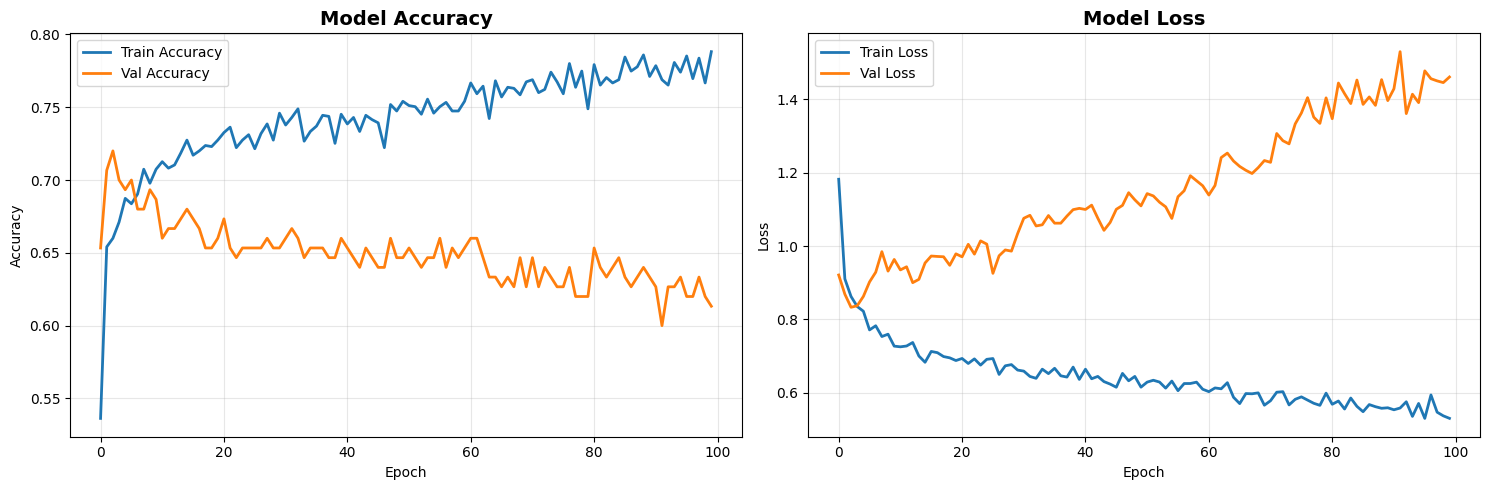

In [16]:
# Cell 11: Plot Training History
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:

# Cell 12: Evaluate Model
# Load best model


# Predictions on validation set
y_val_pred_probs = model.predict(X_val_scaled)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Validation Accuracy: 0.6133 (61.33%)
